<a href="https://colab.research.google.com/github/ebrahimpichka/bayes-portfolio/blob/main/Bayes_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpyro blackjax

In [ ]:
import pytensor
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# pytensor.config.cxx = ""

In [ ]:
## utils

class PortfolioData:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.returns_data = None
        self.market_data = None

    def fetch_data(self):
        """Fetch stock data from Yahoo Finance"""
        data = pd.DataFrame()
        for ticker in self.tickers:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=self.start_date, end=self.end_date)
            data[ticker] = hist['Close'].pct_change()

        # Remove first row (NaN) and any missing values
        self.returns_data = data.dropna()

        # Fetch market data (S&P 500)
        market = yf.Ticker('^GSPC')
        market_hist = market.history(start=self.start_date, end=self.end_date)
        self.market_data = market_hist['Close'].pct_change().dropna()

        return self.returns_data

    def calculate_statistics(self):
        """Calculate basic statistics of returns"""
        statistics = pd.DataFrame()
        statistics['mean'] = self.returns_data.mean() * 252  # Annualized mean
        statistics['std'] = self.returns_data.std() * np.sqrt(252)  # Annualized std
        statistics['sharpe'] = statistics['mean'] / statistics['std']
        return statistics

    def calculate_covariance(self):
        """Calculate the covariance matrix of returns"""
        return self.returns_data.cov() * 252  # Annualized covariance

class MarkowitzOptimizer:
    def __init__(self, returns, risk_free_rate=0.02):
        self.returns = returns
        self.risk_free_rate = risk_free_rate
        self.mean_returns = returns.mean() * 252
        self.cov_matrix = returns.cov() * 252

    def optimize_portfolio(self, target_return=None):
        """
        Optimize portfolio weights for either min variance or target return
        """
        n_assets = len(self.returns.columns)

        def objective(weights):
            portfolio_std = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
            if target_return is None:
                return portfolio_std
            else:
                portfolio_return = np.sum(self.mean_returns * weights)
                return -portfolio_return/portfolio_std  # Maximize Sharpe Ratio

        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Weights sum to 1
        ]

        if target_return is not None:
            constraints.append({
                'type': 'eq',
                'fun': lambda x: np.sum(self.mean_returns * x) - target_return
            })

        bounds = tuple((0, 1) for _ in range(n_assets))

        result = minimize(
            objective,
            n_assets * [1./n_assets],  # Equal weight start
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        return result.x

def plot_efficient_frontier(returns, risk_free_rate=0.02, n_portfolios=100):
    """Plot the efficient frontier"""
    optimizer = MarkowitzOptimizer(returns, risk_free_rate)

    # Generate random portfolios
    n_assets = len(returns.columns)
    returns_array = []
    std_array = []
    weights_array = []

    for _ in range(n_portfolios):
        weights = np.random.random(n_assets)
        weights = weights / np.sum(weights)
        weights_array.append(weights)

        portfolio_return = np.sum(optimizer.mean_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(optimizer.cov_matrix, weights)))

        returns_array.append(portfolio_return)
        std_array.append(portfolio_std)

    plt.figure(figsize=(10, 6))
    plt.scatter(std_array, returns_array, c=returns_array/np.array(std_array),
                marker='o', cmap='viridis', s=10, alpha=0.3)

    plt.colorbar(label='Sharpe ratio')
    plt.xlabel('Standard deviation')
    plt.ylabel('Expected return')
    plt.title('Efficient Frontier')

    return plt.gcf()

In [ ]:
class BayesianPortfolio:
    def __init__(self, returns_data, market_data=None):
        self.returns_data = returns_data.values  # Convert to numpy array
        self.market_data = market_data.values if market_data is not None else None
        self.n_assets = returns_data.shape[1]
        self.trace = None

    def build_model(self, use_market_prior=True):
        """Build Bayesian model for returns"""
        with pm.Model() as model:
            # Prior for mean returns
            if use_market_prior and self.market_data is not None:
                market_mean = np.mean(self.market_data)
                market_std = np.std(self.market_data)
                mu = pm.Normal('mu',
                             mu=market_mean * np.ones(self.n_assets),
                             sigma=market_std * np.ones(self.n_assets),
                             shape=self.n_assets)
            else:
                mu = pm.Normal('mu', mu=0, sigma=0.1, shape=self.n_assets)

            # Create the standard deviation distribution
            sd_dist = pm.HalfNormal.dist(sigma=0.1, shape=self.n_assets)

            # LKJ Cholesky covariance
            chol, corr, stds = pm.LKJCholeskyCov(
                'chol',
                n=self.n_assets,
                eta=2.0,
                sd_dist=sd_dist,
                compute_corr=True,
                store_in_trace=True
            )

            # Compute covariance matrix
            cov = pm.Deterministic('cov', chol @ chol.T)

            # Likelihood
            returns = pm.MvNormal('returns',
                                mu=mu,
                                chol=chol,  # Use Cholesky decomposition directly
                                observed=self.returns_data)

        return model

    def sample_posterior(self, model, samples=5000, tune=1000):
        """Sample from the posterior distribution"""
        with model:
            self.trace = pm.sample(
                draws=samples,
                tune=tune,
                nuts_sampler="blackjax",
                random_seed=23,
                # cores=1,
                # chains=2,
                # target_accept=0.9,
            )
        return self.trace

    def optimize_portfolio(self, risk_aversion=3.0):
        """Optimize portfolio weights using posterior samples"""
        if self.trace is None:
            raise ValueError("Must run sample_posterior before optimization")

        # Get posterior samples - access through posterior group
        mu_samples = self.trace.posterior['mu'].values.reshape(-1, self.n_assets)
        cov_samples = self.trace.posterior['cov'].values.reshape(-1, self.n_assets, self.n_assets)

        n_samples = len(mu_samples)
        optimal_weights = np.zeros((n_samples, self.n_assets))

        for i in range(n_samples):
            weights = self._optimize_single(mu_samples[i], cov_samples[i], risk_aversion)
            optimal_weights[i] = weights

        return optimal_weights

    def _optimize_single(self, mu, cov, risk_aversion):
        """Optimize portfolio for single set of parameters"""
        from scipy.optimize import minimize

        def objective(weights):
            portfolio_return = np.sum(mu * weights)
            portfolio_var = np.dot(weights.T, np.dot(cov, weights))
            utility = portfolio_return - 0.5 * risk_aversion * portfolio_var
            return -utility  # Minimize negative utility

        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Weights sum to 1
        ]

        bounds = tuple((0, 1) for _ in range(self.n_assets))

        result = minimize(
            objective,
            self.n_assets * [1./self.n_assets],  # Equal weight start
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        return result.x

    def get_statistics(self):
        """Get summary statistics of the posterior distributions"""
        if self.trace is None:
            raise ValueError("Must run sample_posterior before getting statistics")

        # Reshape arrays to combine chains and draws
        mu_samples = self.trace.posterior['mu'].values.reshape(-1, self.n_assets)
        corr_samples = self.trace.posterior['chol_corr'].values.reshape(-1, self.n_assets, self.n_assets)
        std_samples = self.trace.posterior['chol_stds'].values.reshape(-1, self.n_assets)

        stats = {
            'mu': {
                'mean': np.mean(mu_samples, axis=0),
                'std': np.std(mu_samples, axis=0),
                '95%_CI': np.percentile(mu_samples, [2.5, 97.5], axis=0)
            },
            'corr': {
                'mean': np.mean(corr_samples, axis=0),
                'std': np.std(corr_samples, axis=0)
            },
            'std': {
                'mean': np.mean(std_samples, axis=0),
                'std': np.std(std_samples, axis=0)
            }
        }
        return stats

    def plot_weight_distributions(self):
        """Plot posterior distributions of optimal weights"""
        import matplotlib.pyplot as plt
        import seaborn as sns
        import pandas as pd

        optimal_weights = self.optimize_portfolio()

        plt.figure(figsize=(12, 6))
        df = pd.DataFrame(optimal_weights, columns=[f'Asset {i+1}' for i in range(self.n_assets)])
        sns.boxplot(data=df)
        plt.xticks(rotation=45)
        plt.title('Posterior Distribution of Optimal Portfolio Weights')
        plt.tight_layout()
        return plt.gcf()

    def plot_correlation_heatmap(self):
        """Plot heatmap of posterior mean correlations"""
        import matplotlib.pyplot as plt
        import seaborn as sns

        corr_samples = self.trace.posterior['chol_corr'].values.reshape(-1, self.n_assets, self.n_assets)
        mean_corr = np.mean(corr_samples, axis=0)

        plt.figure(figsize=(10, 8))
        sns.heatmap(mean_corr,
                   annot=True,
                   cmap='coolwarm',
                   center=0,
                   vmin=-1,
                   vmax=1)
        plt.title('Posterior Mean Correlation Matrix')
        plt.tight_layout()
        return plt.gcf()

    def plot_efficient_frontier_distribution(self, n_samples=50):
        """
        Plot efficient frontier with uncertainty from Bayesian posterior samples.
        Shows both scatter of possible portfolios and efficient frontiers.

        Parameters
        ----------
        n_samples : int, default=50
            Number of posterior samples to use for plotting

        Returns
        -------
        matplotlib.figure.Figure
            The generated plot
        """
        if self.trace is None:
            raise ValueError("Must run sample_posterior before plotting")

        import matplotlib.pyplot as plt
        import seaborn as sns

        # samples from posterior
        mu_samples = self.trace.posterior['mu'].values.reshape(-1, self.n_assets)
        cov_samples = self.trace.posterior['cov'].values.reshape(-1, self.n_assets, self.n_assets)

        # random samples if there are too many
        if len(mu_samples) > n_samples:
            indices = np.random.choice(len(mu_samples), n_samples, replace=False)
            mu_samples = mu_samples[indices]
            cov_samples = cov_samples[indices]

        plt.figure(figsize=(12, 8))

        all_portfolio_stds = []
        all_portfolio_rets = []
        all_sharpe_ratios = []

        for i in range(len(mu_samples)):
            mu = mu_samples[i]
            cov = cov_samples[i]

            # Generate random portfolios
            n_portfolios = 1000
            for _ in range(n_portfolios):
                weights = np.random.random(self.n_assets)
                weights = weights / np.sum(weights)

                # Calculate portfolio metrics
                ret = np.sum(mu * weights) * 252  # Annualize
                std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)  # Annualize
                sharpe = (ret - 0.02) / std  # Assuming 2% risk-free rate

                all_portfolio_stds.append(std)
                all_portfolio_rets.append(ret)
                all_sharpe_ratios.append(sharpe)

        all_portfolio_stds = np.array(all_portfolio_stds)
        all_portfolio_rets = np.array(all_portfolio_rets)
        all_sharpe_ratios = np.array(all_sharpe_ratios)

        scatter = plt.scatter(all_portfolio_stds,
                            all_portfolio_rets,
                            c=all_sharpe_ratios,
                            cmap='viridis',
                            alpha=0.5,
                            s=10)

        colorbar = plt.colorbar(scatter)
        colorbar.set_label('Sharpe Ratio')

        plt.xlabel('Portfolio Standard Deviation (Annualized)')
        plt.ylabel('Portfolio Expected Return (Annualized)')
        plt.title('Portfolio Possibilities and Efficient Frontiers')

        plt.grid(True, alpha=0.3)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.xlim(left=0)
        plt.ylim(bottom=0)

        # efficient frontiers for drawn samples
        n_ef_samples = min(5, len(mu_samples))  # Plot fewer efficient frontiers for clarity
        for i in range(n_ef_samples):
            mu = mu_samples[i]
            cov = cov_samples[i]

            min_ret = np.percentile(all_portfolio_rets, 5)
            max_ret = np.percentile(all_portfolio_rets, 95)
            target_returns = np.linspace(min_ret, max_ret, 50)

            ef_stds = []
            ef_rets = []

            # Calculate efficient frontier points
            for target_ret in target_returns:
                # Optimize for minimum variance at this target return
                def objective(weights):
                    return np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)

                constraints = [
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                    {'type': 'eq', 'fun': lambda x: np.sum(mu * x) * 252 - target_ret}
                ]
                bounds = tuple((0, 1) for _ in range(self.n_assets))

                try:
                    result = minimize(objective,
                                self.n_assets * [1./self.n_assets],
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

                    if result.success:
                        std = result.fun
                        ef_stds.append(std)
                        ef_rets.append(target_ret)
                except:
                    continue

            if ef_stds:
                plt.plot(ef_stds, ef_rets, 'r-', alpha=0.5, linewidth=1)

        plt.tight_layout()
        return plt.gcf()

In [ ]:
from scipy.optimize import minimize

class BlackLittermanModel:
    def __init__(self, market_caps, sigma, risk_free_rate=0.02, risk_aversion=3.0):
        self.market_caps = market_caps
        self.sigma = sigma  # Covariance matrix
        self.risk_free_rate = risk_free_rate
        self.risk_aversion = risk_aversion
        self.w_mkt = market_caps / market_caps.sum()  # Market weights

    def calculate_implied_returns(self):
        """Calculate implied market equilibrium returns"""
        implied_returns = self.risk_aversion * np.dot(self.sigma, self.w_mkt)
        return implied_returns + self.risk_free_rate

    def incorporate_views(self, P, Q, omega):
        """
        Incorporate investor views using Black-Litterman formula

        Parameters:
        P: View matrix (k x n), where k is number of views and n is number of assets
        Q: Expected returns for each view
        omega: Confidence matrix for views (diagonal matrix)
        """
        pi = self.calculate_implied_returns()
        tau = 0.05  # Uncertainty scaling factor

        # Black-Litterman formula
        temp = np.linalg.inv(tau * self.sigma)
        omega_inv = np.linalg.inv(omega)
        P_transpose = P.T

        # Posterior mean
        term1 = np.linalg.inv(temp + np.dot(P_transpose, np.dot(omega_inv, P)))
        term2 = np.dot(temp, pi) + np.dot(P_transpose, np.dot(omega_inv, Q))
        posterior_mean = np.dot(term1, term2)

        # Posterior covariance
        posterior_cov = np.linalg.inv(temp + np.dot(P_transpose, np.dot(omega_inv, P)))

        return posterior_mean, posterior_cov

    def optimize_portfolio(self, posterior_mean, posterior_cov):
        """
        Optimize portfolio weights using Black-Litterman posterior estimates
        """
        n_assets = len(posterior_mean)

        def objective(weights):
            portfolio_return = np.sum(posterior_mean * weights)
            portfolio_var = np.dot(weights.T, np.dot(posterior_cov, weights))
            utility = portfolio_return - 0.5 * self.risk_aversion * portfolio_var
            return -utility

        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        ]

        bounds = tuple((0, 1) for _ in range(n_assets))

        result = minimize(
            objective,
            n_assets * [1./n_assets],
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        return result.x

    def plot_weight_comparison(self, bl_weights):
        """Plot comparison of market weights vs Black-Litterman weights"""
        assets = range(len(self.w_mkt))

        plt.figure(figsize=(12, 6))
        width = 0.35

        plt.bar(assets, self.w_mkt, width, label='Market weights')
        plt.bar([x + width for x in assets], bl_weights, width, label='BL weights')

        plt.xlabel('Assets')
        plt.ylabel('Weight')
        plt.title('Market Weights vs Black-Litterman Weights')
        plt.legend()
        plt.tight_layout()

        return plt.gcf()


In [ ]:
  # 1. Set up parameters
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'BRK-B', 'JNJ', 'JPM', 'V', 'PG']
start_date = '2019-01-01'
end_date = '2024-01-01'
risk_free_rate = 0.02  # 2% risk-free rate

# Fetch and prepare data
print(">> Fetching data...")
portfolio = PortfolioData(tickers, start_date, end_date)
returns = portfolio.fetch_data()

# Classical Markowitz Analysis
print("\n>> Performing Classical Markowitz Analysis...")
markowitz = MarkowitzOptimizer(returns, risk_free_rate)

# Plot efficient frontier
ef_plot = plot_efficient_frontier(returns, n_portfolios=50000)
ef_plot.savefig('efficient_frontier.png')
plt.close()

# Calculate optimal portfolio
optimal_weights_markowitz = markowitz.optimize_portfolio()

#########################################################

# 2. Bayesian Analysis
print("\n>> Performing Bayesian Analysis...")
bayesian = BayesianPortfolio(returns, portfolio.market_data)

# Build and sample from model
model = bayesian.build_model(use_market_prior=True)
trace = bayesian.sample_posterior(model, samples=5000, tune=500)


>> Fetching data...

>> Performing Classical Markowitz Analysis...

>> Performing Bayesian Analysis...
Running window adaptation


In [ ]:
az.summary(trace, hdi_prob=0.95, round_to=6, var_names=["mu"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.001497,0.000574,0.000366,0.002596,0.000006,0.000004,10019.231350,7468.613456,1.000049
mu[1],0.001268,0.000539,0.000254,0.002359,0.000005,0.000004,10354.790660,7033.341589,1.000124
mu[2],0.000969,0.000562,-0.000100,0.002123,0.000006,0.000004,9928.924589,6833.612519,1.000110
mu[3],0.000779,0.000624,-0.000430,0.002012,0.000006,0.000005,10172.950300,7540.875054,1.000111
mu[4],0.001137,0.000775,-0.000344,0.002686,0.000008,0.000006,10175.398227,7090.273423,1.000113
mu[5],0.000541,0.000388,-0.000233,0.001288,0.000004,0.000003,10694.192835,8365.564997,0.999954
mu[6],0.000347,0.000350,-0.000308,0.001080,0.000003,0.000003,10373.644917,9546.595495,1.000030
mu[7],0.000748,0.000567,-0.000386,0.001811,0.000005,0.000004,10978.528021,8308.523620,1.000169
mu[8],0.000714,0.000496,-0.000247,0.001696,0.000005,0.000004,10562.424147,7808.554397,1.000121
mu[9],0.000566,0.000376,-0.000151,0.001316,0.000004,0.000003,10562.052978,8857.811671,1.000007


In [ ]:
# Get optimal weights distribution
optimal_weights_bayesian = bayesian.optimize_portfolio()

# Plot weight distributions
weight_plot = bayesian.plot_weight_distributions()
weight_plot.savefig('bayesian_weights.png')
plt.close()

# Plot Bayesian efficient frontier
ef_bayes_plot = bayesian.plot_efficient_frontier_distribution(n_samples=10)
ef_bayes_plot.savefig('bayesian_efficient_frontier.png')
plt.close()

#########################################################

# 3. Black-Litterman Analysis with Bayesian-informed views
print("\n>> Performing Black-Litterman Analysis...")

# Get market capitalizations (simplified - using equal weights here)
market_caps = np.ones(len(tickers))
sigma = returns.cov().values * 252  # Annualized covariance

# Get Bayesian analysis results for informed views
bayesian_means = trace.posterior['mu'].mean(dim=['chain', 'draw']).values
bayesian_stds = trace.posterior['mu'].std(dim=['chain', 'draw']).values

# Setup views based on strongest signals from Bayesian analysis
signal_strength = bayesian_means / bayesian_stds  # Information ratio
top_signals = np.argsort(signal_strength)[-3:]  # Top 3 strongest signals

# Create view matrix
n_views = len(top_signals)
P = np.zeros((n_views, len(tickers)))
Q = np.zeros(n_views)
omega = np.zeros((n_views, n_views))  # Diagonal confidence matrix

for i, asset_idx in enumerate(top_signals):
    P[i, asset_idx] = 1  # Single asset view
    Q[i] = bayesian_means[asset_idx]  # Expected return from Bayesian analysis
    omega[i, i] = bayesian_stds[asset_idx]**2  # Uncertainty from Bayesian analysis

# Black-Litterman Analysis
bl_model = BlackLittermanModel(market_caps, sigma, risk_free_rate)
posterior_mean, posterior_cov = bl_model.incorporate_views(P, Q, omega)
optimal_weights_bl = bl_model.optimize_portfolio(posterior_mean, posterior_cov)

# Plot comparison
weight_comparison = bl_model.plot_weight_comparison(optimal_weights_bl)
weight_comparison.savefig('bl_comparison.png')
plt.close()

# Results Analysis and Comparison
print("\n>> Analyzing Results...")

# Create results DataFrame
results = pd.DataFrame({
    'Markowitz': optimal_weights_markowitz,
    'Black-Litterman': optimal_weights_bl,
    'Bayesian_Mean': optimal_weights_bayesian.mean(axis=0),
    'Bayesian_Std': optimal_weights_bayesian.std(axis=0)
}, index=tickers)

# Calculate performance metrics
def calculate_portfolio_metrics(weights):
    portfolio_return = np.sum(returns.mean() * 252 * weights)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_vol
    return pd.Series({
        'Return': portfolio_return,
        'Volatility': portfolio_vol,
        'Sharpe': sharpe_ratio
    })

metrics = pd.DataFrame({
    'Markowitz': calculate_portfolio_metrics(optimal_weights_markowitz),
    'Black-Litterman': calculate_portfolio_metrics(optimal_weights_bl),
    'Bayesian': calculate_portfolio_metrics(optimal_weights_bayesian.mean(axis=0))
})

# Save Results
print("\n>> Saving Results...")

# Save numerical results
results.to_csv('portfolio_weights.csv')
metrics.to_csv('portfolio_metrics.csv')

# summary report
with open('analysis_report.txt', 'w') as f:
    f.write("Portfolio Optimization Analysis Report\n")
    f.write("====================================\n\n")
    f.write(f"Analysis Period: {start_date} to {end_date}\n")
    f.write(f"Assets Analyzed: {', '.join(tickers)}\n\n")

    f.write("Portfolio Weights:\n")
    f.write(results.to_string())
    f.write("\n\n")

    f.write("Performance Metrics:\n")
    f.write(metrics.to_string())
    f.write("\n\n")

    f.write("\nBayesian Analysis Views:\n")
    f.write("----------------------\n")
    for i, asset_idx in enumerate(top_signals):
        f.write(f"View {i+1}: {tickers[asset_idx]}\n")
        f.write(f"Expected Return: {Q[i]:.4f}\n")
        f.write(f"Confidence (1/variance): {1/omega[i,i]:.4f}\n")



>> Performing Black-Litterman Analysis...

>> Analyzing Results...

>> Saving Results...


In [ ]:
def analyze_trace(trace, param_names=None, save_prefix='mcmc_'):
    """
    Comprehensive analysis of MCMC samples using ArviZ.

    Parameters
    ----------
    trace : InferenceData
        The trace object from PyMC sampling
    param_names : list of str, optional
        List of parameter names to analyze. If None, analyzes all parameters
    save_prefix : str, optional
        Prefix for saving plot files

    Returns
    -------
    dict
        Dictionary containing summary statistics and diagnostics
    """
    results = {}

    # If no specific parameters provided, get all from trace
    if param_names is None:
        param_names = list(trace.posterior.data_vars)

    # Summary stats
    summary = az.summary(trace, var_names=param_names)
    results['summary'] = summary

    # Trace plots
    for param in param_names:
        plt.figure(figsize=(12, 6))
        az.plot_trace(trace, var_names=[param])
        plt.tight_layout()
        plt.savefig(f'{save_prefix}trace_{param}.png')
        plt.close()

    # Posterior distributions
    plt.figure(figsize=(12, 6))
    az.plot_posterior(trace, var_names=param_names)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}posterior.png')
    plt.close()

    # Forest plot (useful for comparing parameters)
    plt.figure(figsize=(12, 8))
    az.plot_forest(trace, var_names=param_names)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}forest.png')
    plt.close()

    # Energy plot for sampling diagnostics
    plt.figure(figsize=(8, 6))
    az.plot_energy(trace)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}energy.png')
    plt.close()

    # Rank plots for assessing convergence
    plt.figure(figsize=(12, 8))
    az.plot_rank(trace, var_names=param_names)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}rank.png')
    plt.close()

    # Convergence statistics
    results['r_hat'] = az.rhat(trace)
    results['ess'] = az.ess(trace)
    results['mcse'] = az.mcse(trace)

    # Pair plot for parameter correlations
    if len(param_names) > 1:
        plt.figure(figsize=(12, 12))
        az.plot_pair(trace, var_names=param_names,
                    kind=['scatter', 'kde'],
                    marginals=True)
        plt.tight_layout()
        plt.savefig(f'{save_prefix}pair.png')
        plt.close()

    # ESS vs autocorrelation time plot
    plt.figure(figsize=(10, 6))
    az.plot_ess(trace, var_names=param_names)
    plt.tight_layout()
    plt.savefig(f'{save_prefix}ess.png')
    plt.close()

    # # Create diagnostics summary
    # diagnostics = pd.DataFrame({
    #     'r_hat': results['r_hat'],
    #     'ess_bulk': results['ess']['ess_bulk'],
    #     'ess_tail': results['ess']['ess_tail'],
    #     'mcse_mean': results['mcse'].sel(metric='mean'),
    #     'mcse_sd': results['mcse'].sel(metric='sd')
    # })
    # results['diagnostics'] = diagnostics

    # # Save summary statistics to file
    # summary.to_csv(f'{save_prefix}summary.csv')
    # diagnostics.to_csv(f'{save_prefix}diagnostics.csv')

    # # Add interpretation guidelines
    # results['interpretation'] = {
    #     'r_hat_ok': all(results['r_hat'].values < 1.05),
    #     'ess_ok': all(results['ess']['ess_bulk'].values > 400),
    #     'recommendations': []
    # }

    # # Add recommendations based on diagnostics
    # if not results['interpretation']['r_hat_ok']:
    #     results['interpretation']['recommendations'].append(
    #         "Some parameters show poor convergence (r_hat > 1.05). Consider increasing the number of iterations."
    #     )
    # if not results['interpretation']['ess_ok']:
    #     results['interpretation']['recommendations'].append(
    #         "Low effective sample size for some parameters. Consider increasing the number of samples or reducing autocorrelation."
    #     )

    return results

In [ ]:
diag = analyze_trace(
    trace,
    param_names=["mu"],
    save_prefix='portfolio_mcmc_'  # prefix for saved files
)

# Check results
print("\nSummary Statistics:")
print(diag['summary'])

print("\nDiagnostics:")
print(diag['diagnostics'])

print("\nRecommendations:")
for rec in diag['interpretation']['recommendations']:
    print(f"- {rec}")

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)



Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu[0]  0.001  0.001     0.0    0.003        0.0      0.0   10019.0    7469.0   
mu[1]  0.001  0.001     0.0    0.002        0.0      0.0   10355.0    7033.0   
mu[2]  0.001  0.001    -0.0    0.002        0.0      0.0    9929.0    6834.0   
mu[3]  0.001  0.001    -0.0    0.002        0.0      0.0   10173.0    7541.0   
mu[4]  0.001  0.001    -0.0    0.003        0.0      0.0   10175.0    7090.0   
mu[5]  0.001  0.000    -0.0    0.001        0.0      0.0   10694.0    8366.0   
mu[6]  0.000  0.000    -0.0    0.001        0.0      0.0   10374.0    9547.0   
mu[7]  0.001  0.001    -0.0    0.002        0.0      0.0   10979.0    8309.0   
mu[8]  0.001  0.000    -0.0    0.002        0.0      0.0   10562.0    7809.0   
mu[9]  0.001  0.000    -0.0    0.001        0.0      0.0   10562.0    8858.0   

       r_hat  
mu[0]    1.0  
mu[1]    1.0  
mu[2]    1.0  
mu[3]    1.0  
mu[4]    1.0  
mu[5]   

KeyError: 'diagnostics'

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
def plot_comparison_analysis(results, metrics):
    plt.figure(figsize=(15, 10))

    # Create subplot grid
    gs = plt.GridSpec(2, 2)

    # Weight comparison
    ax1 = plt.subplot(gs[0, :])

    # Plot bars for each method
    x = np.arange(len(results.index))
    width = 0.25

    # Plot Markowitz weights
    ax1.bar(x - width, results['Markowitz'], width, label='Markowitz')

    # Plot Black-Litterman weights
    ax1.bar(x, results['Black-Litterman'], width, label='Black-Litterman')

    # Plot Bayesian weights with error bars
    ax1.bar(x + width, results['Bayesian_Mean'], width, label='Bayesian',
            yerr=results['Bayesian_Std'], capsize=5)

    ax1.set_title('Portfolio Weights Comparison')
    ax1.set_xlabel('Assets')
    ax1.set_ylabel('Weight')
    ax1.set_xticks(x)
    ax1.set_xticklabels(results.index, rotation=45)
    ax1.legend()

    # Performance metrics
    ax2 = plt.subplot(gs[1, 0])
    metrics.plot(kind='bar', ax=ax2)
    ax2.set_title('Performance Metrics')
    ax2.set_xlabel('Metric')
    ax2.set_ylabel('Value')
    plt.xticks(rotation=45)

    # Risk-return scatter
    ax3 = plt.subplot(gs[1, 1])
    plt.scatter(metrics.loc['Volatility'], metrics.loc['Return'],
               c=metrics.loc['Sharpe'], cmap='viridis')
    for i, txt in enumerate(metrics.columns):
        ax3.annotate(txt, (metrics.loc['Volatility'][i], metrics.loc['Return'][i]))
    ax3.set_xlabel('Volatility')
    ax3.set_ylabel('Return')
    ax3.set_title('Risk-Return Comparison')

    plt.tight_layout()
    plt.savefig('comparison_analysis.png')
    return plt.gcf()


<ipython-input-14-9fe30cf37470>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.annotate(txt, (metrics.loc['Volatility'][i], metrics.loc['Return'][i]))


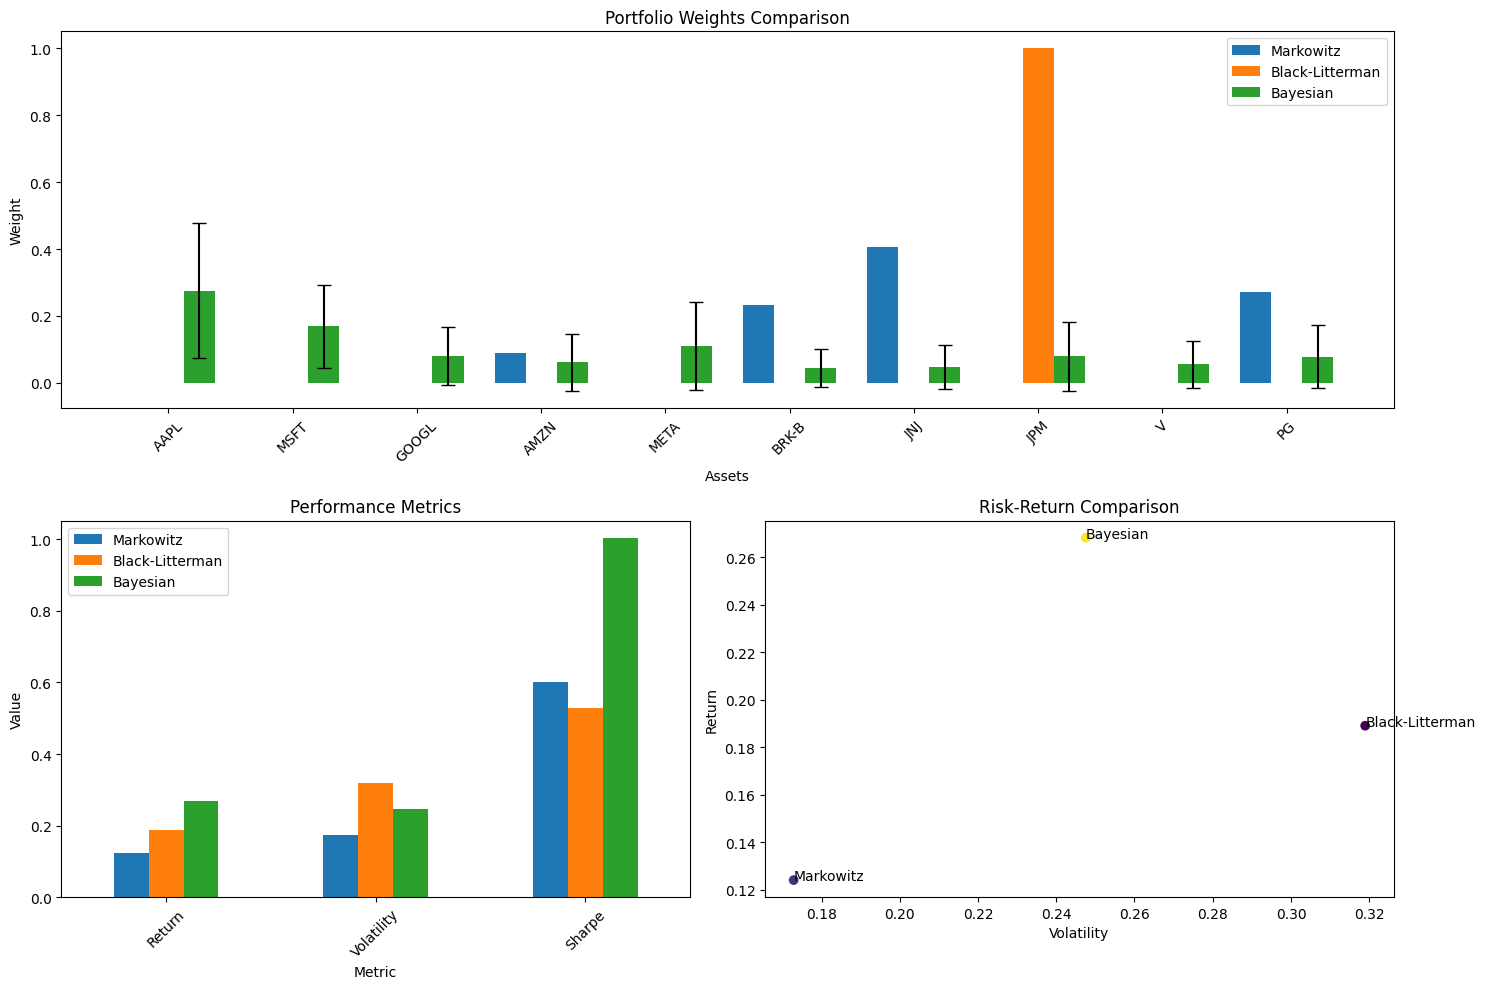

In [ ]:
comparison_plot = plot_comparison_analysis(results, metrics)


In [ ]:
print(metrics.to_latex())

\begin{tabular}{lrrr}
\toprule
 & Markowitz & Black-Litterman & Bayesian \\
\midrule
Return & 0.124047 & 0.189012 & 0.268134 \\
Volatility & 0.172877 & 0.318977 & 0.247576 \\
Sharpe & 0.601855 & 0.529855 & 1.002252 \\
\bottomrule
\end{tabular}



In [ ]:
print(results[['Markowitz', 'Bayesian_Mean', 'Bayesian_Std']].to_latex())

\begin{tabular}{lrrr}
\toprule
 & Markowitz & Bayesian_Mean & Bayesian_Std \\
\midrule
AAPL & 0.000000 & 0.275700 & 0.200835 \\
MSFT & 0.000000 & 0.168853 & 0.123390 \\
GOOGL & 0.000000 & 0.080087 & 0.086049 \\
AMZN & 0.089917 & 0.061834 & 0.085022 \\
META & 0.000000 & 0.109067 & 0.131770 \\
BRK-B & 0.232597 & 0.044240 & 0.056664 \\
JNJ & 0.406633 & 0.047624 & 0.065810 \\
JPM & 0.000000 & 0.079069 & 0.103171 \\
V & 0.000000 & 0.054906 & 0.069855 \\
PG & 0.270853 & 0.078619 & 0.093299 \\
\bottomrule
\end{tabular}



In [ ]:
print(az.summary(trace, hdi_prob=0.95, round_to=6, var_names=["mu"]).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
 & mean & sd & hdi_2.5% & hdi_97.5% & mcse_mean & mcse_sd & ess_bulk & ess_tail & r_hat \\
\midrule
mu[0] & 0.001497 & 0.000574 & 0.000366 & 0.002596 & 0.000006 & 0.000004 & 10019.231350 & 7468.613456 & 1.000049 \\
mu[1] & 0.001268 & 0.000539 & 0.000254 & 0.002359 & 0.000005 & 0.000004 & 10354.790660 & 7033.341589 & 1.000124 \\
mu[2] & 0.000969 & 0.000562 & -0.000100 & 0.002123 & 0.000006 & 0.000004 & 9928.924589 & 6833.612519 & 1.000110 \\
mu[3] & 0.000779 & 0.000624 & -0.000430 & 0.002012 & 0.000006 & 0.000005 & 10172.950300 & 7540.875054 & 1.000111 \\
mu[4] & 0.001137 & 0.000775 & -0.000344 & 0.002686 & 0.000008 & 0.000006 & 10175.398227 & 7090.273423 & 1.000113 \\
mu[5] & 0.000541 & 0.000388 & -0.000233 & 0.001288 & 0.000004 & 0.000003 & 10694.192835 & 8365.564997 & 0.999954 \\
mu[6] & 0.000347 & 0.000350 & -0.000308 & 0.001080 & 0.000003 & 0.000003 & 10373.644917 & 9546.595495 & 1.000030 \\
mu[7] & 0.000748 & 0.000567 & -0.000386 & 0.001811 & 0

In [ ]:
print(az.summary(trace, hdi_prob=0.95, round_to=4, var_names=["chol"]).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
 & mean & sd & hdi_2.5% & hdi_97.5% & mcse_mean & mcse_sd & ess_bulk & ess_tail & r_hat \\
\midrule
chol[0] & 0.020100 & 0.000400 & 0.019300 & 0.020900 & 0.000000 & 0.000000 & 11096.908900 & 6528.718500 & 1.000100 \\
chol[1] & 0.014200 & 0.000400 & 0.013400 & 0.015100 & 0.000000 & 0.000000 & 10669.279200 & 9075.903800 & 1.000200 \\
chol[2] & 0.012600 & 0.000300 & 0.012100 & 0.013000 & 0.000000 & 0.000000 & 10577.661300 & 6957.259000 & 1.000400 \\
chol[3] & 0.013200 & 0.000500 & 0.012200 & 0.014100 & 0.000000 & 0.000000 & 10035.013600 & 9163.849500 & 1.000000 \\
chol[4] & 0.007600 & 0.000400 & 0.006800 & 0.008300 & 0.000000 & 0.000000 & 10329.995800 & 8666.157000 & 1.000000 \\
chol[5] & 0.012800 & 0.000300 & 0.012300 & 0.013300 & 0.000000 & 0.000000 & 11169.535400 & 6487.418100 & 1.000200 \\
chol[6] & 0.013400 & 0.000600 & 0.012300 & 0.014500 & 0.000000 & 0.000000 & 10724.982600 & 9323.358400 & 1.000100 \\
chol[7] & 0.007200 & 0.000500 & 0.006300 & 0